In [ ]:
!pip install tensorflow tensorflow-datasets matplotlib librosa


In [58]:
!pip install pydub


In [ ]:
!apt-get update && apt-get install -y ffmpeg


In [60]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import tensorflow_datasets as tfds

In [61]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [62]:
# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [63]:

# Ruta base para guardar el dataset organizado
output_folder = '/content/organized_audio_dataset'

# Crear carpeta base si no existe
os.makedirs(output_folder, exist_ok=True)


In [64]:

# Idiomas seleccionados
LANGUAGES = {
    "español": "fleurs.es_419",
    "inglés": "fleurs.en_us",
    "francés": "fleurs.fr_fr",
    "japonés": "fleurs.ja_jp",
}

for lang, config in LANGUAGES.items():
    lang_folder = os.path.join(output_folder, lang)
    os.makedirs(lang_folder, exist_ok=True)  # Crear carpeta para el idioma

    print(f"Organizando datos para el idioma: {lang}")

    dataset = tfds.load(
        "xtreme_s",
        split="train",
        as_supervised=True,
        builder_kwargs={"config": config}
    )

    for idx, (audio, _) in enumerate(dataset):
        # Convertir audio a float32
        audio_float = tf.cast(audio, tf.float32)

        # Normalizar el audio al rango [-1.0, 1.0]
        audio_normalized = audio_float / tf.reduce_max(tf.abs(audio_float))

        # Agregar una dimensión para el canal (mono)
        audio_with_channel = tf.expand_dims(audio_normalized, axis=-1)

        # Crear nombre de archivo
        filename = f"{lang}_{idx}.wav"
        filepath = os.path.join(lang_folder, filename)

        try:
            # Generar un tensor WAV con tf.audio.encode_wav
            wav_tensor = tf.audio.encode_wav(audio_with_channel, sample_rate=16000)

            # Escribir el archivo WAV en el sistema
            with open(filepath, 'wb') as f:
                f.write(wav_tensor.numpy())
        except Exception as e:
            print(f"Error al guardar el archivo {filename}: {e}")

print(f"Archivos organizados en: {output_folder}")

Organizando datos para el idioma: español
Organizando datos para el idioma: inglés
Organizando datos para el idioma: francés
Organizando datos para el idioma: japonés
Archivos organizados en: /content/organized_audio_dataset


In [65]:
for lang in LANGUAGES.keys():
    lang_folder = os.path.join(output_folder, lang)
    print(f"Archivos en la carpeta '{lang}':", len(os.listdir(lang_folder)))

Archivos en la carpeta 'español': 2796
Archivos en la carpeta 'inglés': 2602
Archivos en la carpeta 'francés': 3193
Archivos en la carpeta 'japonés': 2292


In [66]:
from sklearn.model_selection import train_test_split
import shutil

# Crear carpetas para train y val
train_folder = os.path.join(output_folder, "train")
val_folder = os.path.join(output_folder, "val")

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Dividir los archivos para cada idioma
for lang in LANGUAGES.keys():
    lang_dir = os.path.join(output_folder, lang)
    all_files = os.listdir(lang_dir)

    # Dividir en 80% entrenamiento y 20% validación
    train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

    # Crear carpetas para este idioma en train y val
    lang_train_folder = os.path.join(train_folder, lang)
    lang_val_folder = os.path.join(val_folder, lang)
    os.makedirs(lang_train_folder, exist_ok=True)
    os.makedirs(lang_val_folder, exist_ok=True)

    # Mover archivos
    for file in train_files:
        shutil.move(os.path.join(lang_dir, file), os.path.join(lang_train_folder, file))
    for file in val_files:
        shutil.move(os.path.join(lang_dir, file), os.path.join(lang_val_folder, file))

print("Datos divididos en entrenamiento y validación.")


Datos divididos en entrenamiento y validación.


BALANCEO DE CLASES

In [67]:
from collections import Counter

def count_files_in_folders(folder_path):
    counts = {}
    for lang in LANGUAGES.keys():
        lang_folder = os.path.join(folder_path, lang)
        counts[lang] = len(os.listdir(lang_folder))
    return counts

# Contar ejemplos en train y val
train_counts = count_files_in_folders(train_folder)
val_counts = count_files_in_folders(val_folder)

print("Distribución de clases en entrenamiento:", train_counts)
print("Distribución de clases en validación:", val_counts)


Distribución de clases en entrenamiento: {'español': 2236, 'inglés': 2081, 'francés': 2554, 'japonés': 1833}
Distribución de clases en validación: {'español': 560, 'inglés': 521, 'francés': 639, 'japonés': 459}


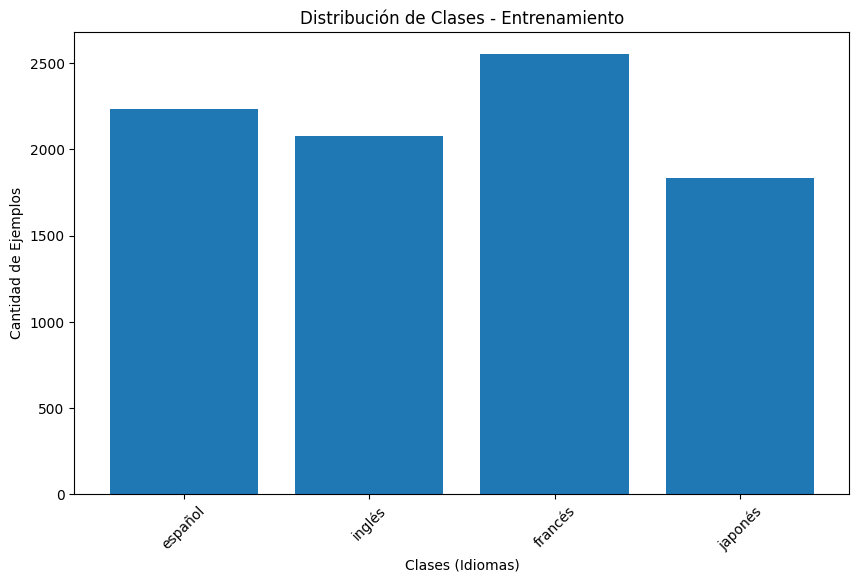

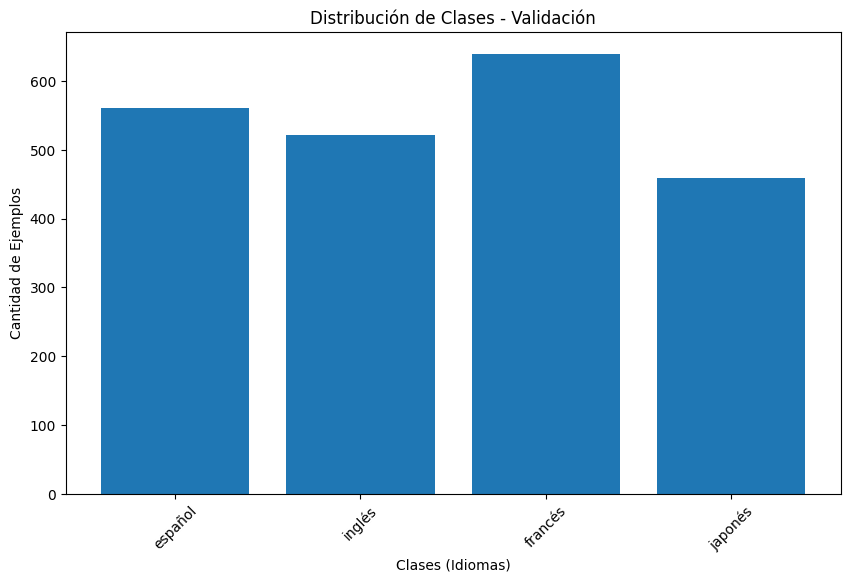

In [68]:
# Crear el gráfico de barras
def plot_class_balance(counts, title):
    plt.figure(figsize=(10, 6))
    plt.bar(counts.keys(), counts.values())
    plt.xlabel("Clases (Idiomas)")
    plt.ylabel("Cantidad de Ejemplos")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Gráficos para entrenamiento y validación
plot_class_balance(train_counts, "Distribución de Clases - Entrenamiento")
plot_class_balance(val_counts, "Distribución de Clases - Validación")

PREPROCESAMIENTO DE LOS ARCHIVOS DE AUDIO

In [71]:
def squeeze(audio, labels):
    # Eliminar el eje extra del canal, si existe
    if len(audio.shape) > 1 and audio.shape[-1] == 1:
        audio = tf.squeeze(audio, axis=-1)
    return audio, labels  # Devolver las etiquetas sin cambios

# Aplicar squeeze nuevamente
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Verificar las dimensiones después de aplicar squeeze
for example_audio, example_labels in train_ds.take(1):
    print("Forma de onda después de squeeze:", example_audio.shape)
    print("Etiquetas:", example_labels)



Forma de onda después de squeeze: (80000,)
Etiquetas: tf.Tensor(1, shape=(), dtype=int32)


ESPECTOGRAMAS

---



In [74]:
# Definir la función get_spectrogram
def get_spectrogram(waveform):
    # Convertir la forma de onda en un espectrograma mediante STFT
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
    )
    spectrogram = tf.abs(spectrogram)  # Obtener la magnitud
    spectrogram = spectrogram[..., tf.newaxis]  # Agregar dimensión para el canal
    return spectrogram



In [76]:
# Crear un diccionario para almacenar un ejemplo por etiqueta
examples_per_label = {}

# Iterar sobre el dataset de entrenamiento
for example_audio, example_labels in train_ds:
    # Si la etiqueta es un escalar (por ejemplo, una sola etiqueta por lote)
    if tf.rank(example_labels) == 0:
        label_name = label_names[example_labels.numpy()]
        if label_name not in examples_per_label:
            spectrogram = get_spectrogram(example_audio)
            examples_per_label[label_name] = (example_audio, spectrogram, label_name)
    else:
        # Si hay múltiples etiquetas en el lote, iterar por cada una
        for waveform, label in zip(example_audio, example_labels):
            label_name = label_names[label.numpy()]
            if label_name not in examples_per_label:
                spectrogram = get_spectrogram(waveform)
                examples_per_label[label_name] = (waveform, spectrogram, label_name)

    # Detenernos si tenemos un ejemplo para cada etiqueta
    if len(examples_per_label) == len(label_names):
        break

# Mostrar información de cada ejemplo
for label_name, (waveform, spectrogram, _) in examples_per_label.items():
    print(f'Label: {label_name}')
    print(f'Waveform shape: {waveform.shape}')
    print(f'Spectrogram shape: {spectrogram.shape}')
    print('Audio playback:')
    display.display(display.Audio(waveform.numpy(), rate=16000))


Label: español
Waveform shape: (80000,)
Spectrogram shape: (624, 129, 1)
Audio playback:


Label: inglés
Waveform shape: (80000,)
Spectrogram shape: (624, 129, 1)
Audio playback:


Label: francés
Waveform shape: (80000,)
Spectrogram shape: (624, 129, 1)
Audio playback:


Label: japonés
Waveform shape: (80000,)
Spectrogram shape: (624, 129, 1)
Audio playback:


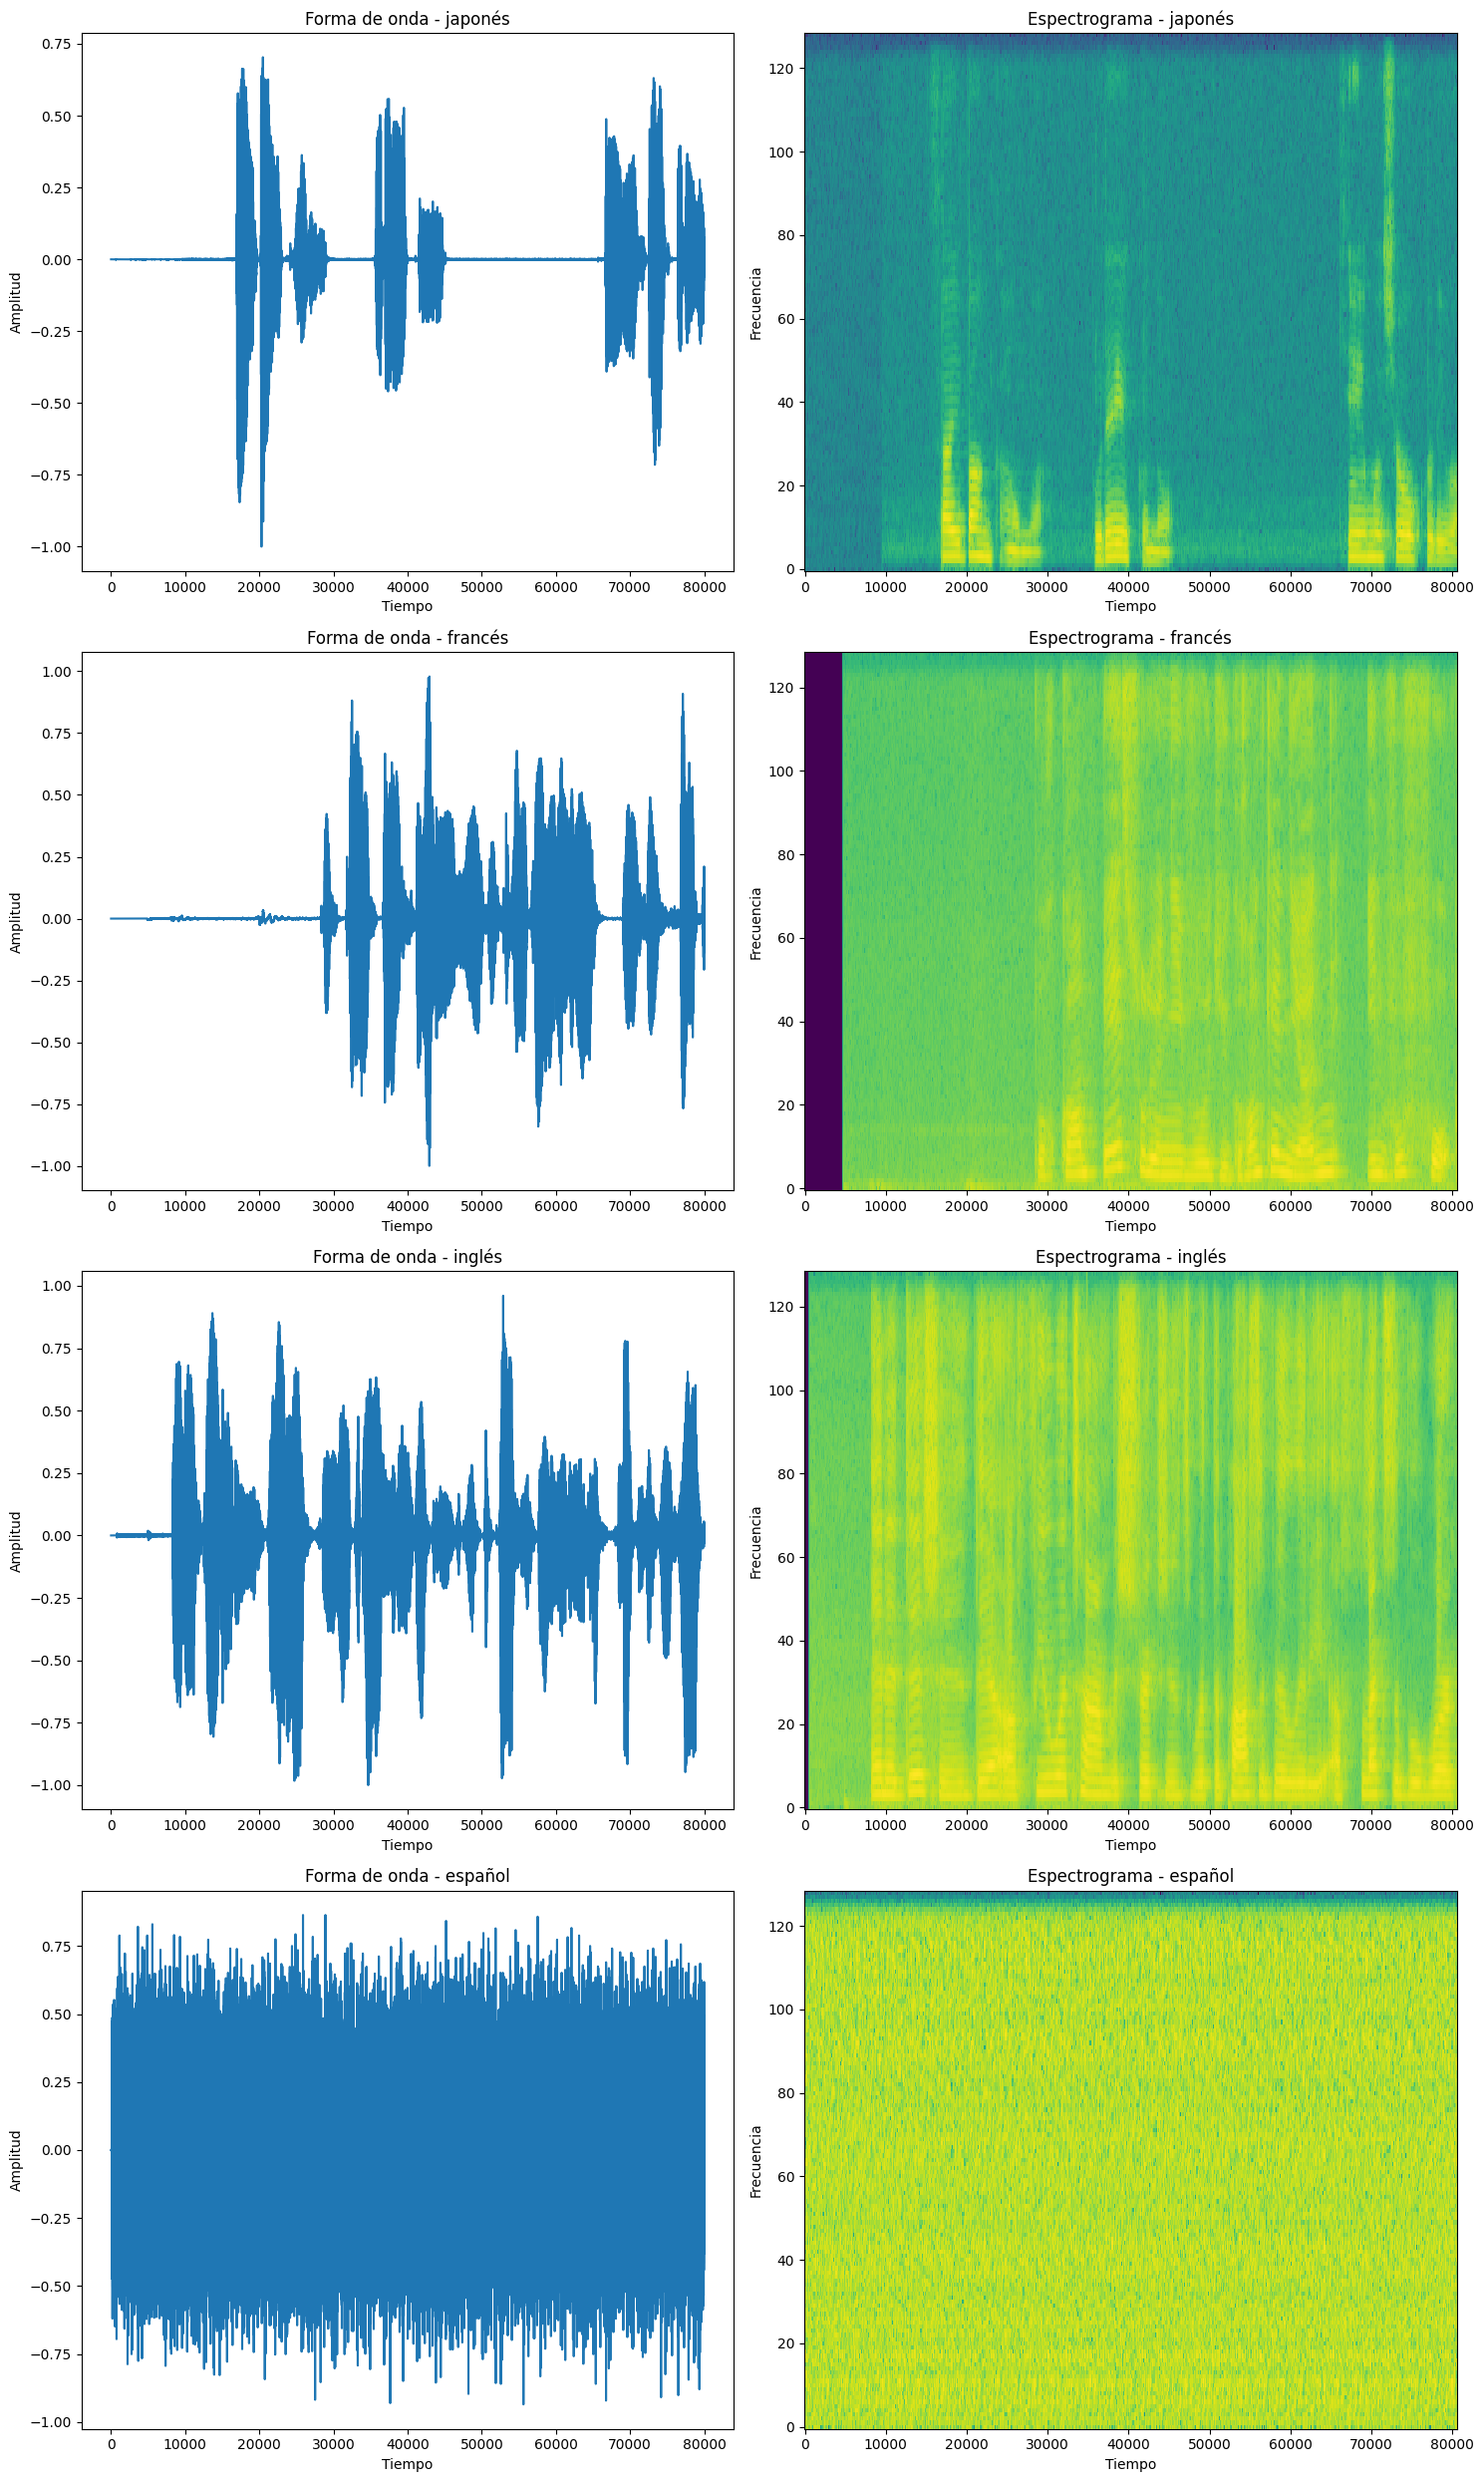

In [82]:
# Crear un diccionario para almacenar un ejemplo por etiqueta
examples_per_label = {}

# Iterar sobre el dataset para recolectar ejemplos únicos por etiqueta
for waveform, label in train_ds:
    label_name = label_names[label.numpy()]  # Convertir etiqueta a nombre
    if label_name not in examples_per_label:
        spectrogram = get_spectrogram(waveform)  # Generar espectrograma
        examples_per_label[label_name] = (waveform, spectrogram, label_name)
    # Detenernos si ya tenemos un ejemplo para cada etiqueta
    if len(examples_per_label) == len(label_names):
        break

# Graficar formas de onda y espectrogramas
fig, axes = plt.subplots(len(examples_per_label), 2, figsize=(15, 25))

for i, (label_name, (waveform, spectrogram, _)) in enumerate(examples_per_label.items()):
    # Graficar forma de onda
    axes[i, 0].plot(np.arange(len(waveform)), waveform.numpy())
    axes[i, 0].set_title(f"Forma de onda - {label_name}")
    axes[i, 0].set_xlabel("Tiempo")
    axes[i, 0].set_ylabel("Amplitud")

    # Graficar espectrograma
    if len(spectrogram.shape) > 2:
        spectrogram = np.squeeze(spectrogram, axis=-1)  # Eliminar eje extra
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)  # Escala logarítmica
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    axes[i, 1].pcolormesh(X, Y, log_spec)
    axes[i, 1].set_title(f"Espectrograma - {label_name}")
    axes[i, 1].set_xlabel("Tiempo")
    axes[i, 1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


In [93]:
# Función para procesar espectrogramas y etiquetas
def preprocess_dataset(dataset):
    def process_entry(spectrogram, label):
        spectrogram = tf.ensure_shape(spectrogram, (None, 129, 1))  # Asegurar forma del espectrograma
        label = tf.cast(label, tf.int32)  # Convertir etiquetas a enteros escalares
        return spectrogram, label

    return dataset.map(process_entry, num_parallel_calls=tf.data.AUTOTUNE)

# Aplicar preprocesamiento
train_spectrogram_ds = preprocess_dataset(train_spectrogram_ds)
val_spectrogram_ds = preprocess_dataset(val_spectrogram_ds)

# Dividir en lotes
train_spectrogram_ds = train_spectrogram_ds.batch(32).cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)

# Verificar ejemplos procesados
for spectrogram, label in train_spectrogram_ds.take(1):
    print(f"Espectrograma shape: {spectrogram.shape}")
    print(f"Etiqueta shape: {label.shape}")


Espectrograma shape: (32, 624, 129, 1)
Etiqueta shape: (32,)


ENTRENAMIENTO DE LOS MODELOS

In [94]:
# Definir la forma de entrada y el número de etiquetas
input_shape = next(iter(train_spectrogram_ds))[0].shape[1:]  # Forma de los espectrogramas
num_labels = len(label_names)  # Número de clases

print('Input shape:', input_shape)

# Instanciar y adaptar la capa de normalización
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


Input shape: (624, 129, 1)


MODELO CONVOLUCIONAL

In [92]:
def build_cnn_model(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=(input_shape[0], input_shape[1], 1)),  # Especificar la dimensión del canal
        layers.Resizing(32, 32),  # Redimensionar
        norm_layer,               # Normalización
        layers.Conv2D(32, 3, activation='relu'),  # Capas convolucionales
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),                   # Pooling
        layers.Dropout(0.25),                    # Regularización
        layers.Flatten(),                        # Aplanar
        layers.Dense(128, activation='relu'),    # Capa densa
        layers.Dropout(0.5),
        layers.Dense(num_labels),                # Capa de salida
    ])
    return model


In [95]:
cnn_model = build_cnn_model(input_shape, num_labels)

# Compilar el modelo CNN
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Entrenar el modelo CNN
cnn_history = cnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)],
)

# Evaluar el modelo CNN
cnn_eval = cnn_model.evaluate(val_spectrogram_ds)
print(f"CNN Validation Loss: {cnn_eval[0]}, CNN Validation Accuracy: {cnn_eval[1]}")


Epoch 1/50
    272/Unknown 37s 129ms/step - accuracy: 0.4944 - loss: 1.1396

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 58s 206ms/step - accuracy: 0.4947 - loss: 1.1392 - val_accuracy: 0.2680 - val_loss: 1.3457
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 34s 127ms/step - accuracy: 0.6879 - loss: 0.7703 - val_accuracy: 0.2194 - val_loss: 1.5067
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 45s 140ms/step - accuracy: 0.7755 - loss: 0.5725 - val_accuracy: 0.2166 - val_loss: 1.5017
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 42s 145ms/step - accuracy: 0.8339 - loss: 0.4392 - val_accuracy: 0.2414 - val_loss: 1.5026
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.8735 - loss: 0.3540 - val_accuracy: 0.2194 - val_loss: 1.6454
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 75s 128ms/step - accuracy: 0.8996 - loss: 0.2893 - val_accuracy: 0.2226 - val_loss: 1.6463
Epoch 6: early stopping
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.2435 - loss: 1.6110
CNN Validation Loss: 1.6463466882705688, CNN Validation Accuracy: 0.22257916629314423


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Ejemplo 1:
Etiqueta real: japonés
Predicción: japonés


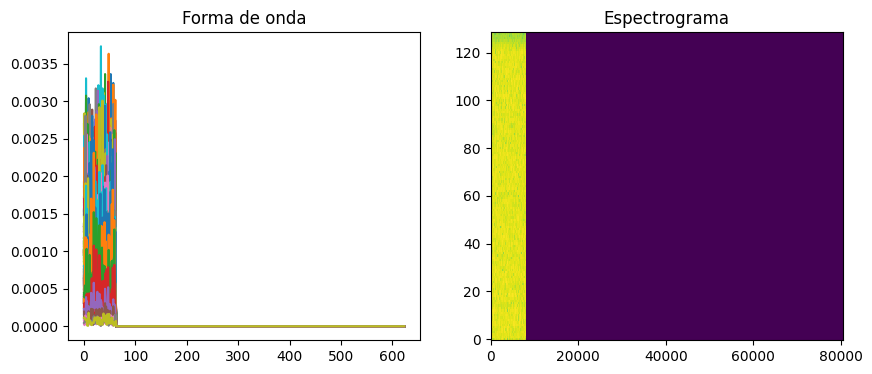

Ejemplo 2:
Etiqueta real: japonés
Predicción: japonés


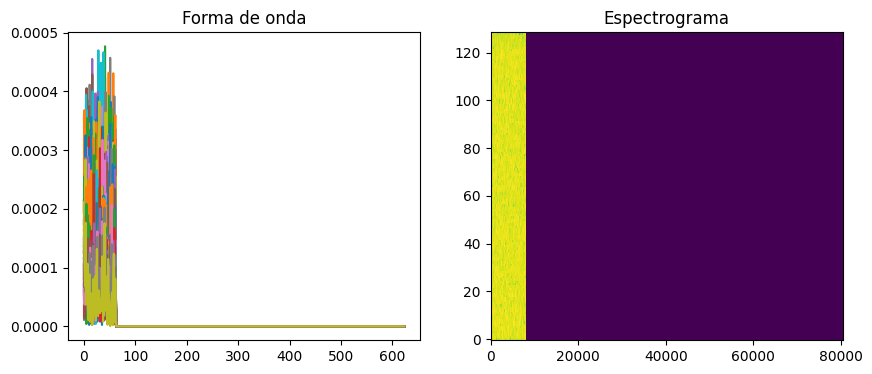

Ejemplo 3:
Etiqueta real: inglés
Predicción: japonés


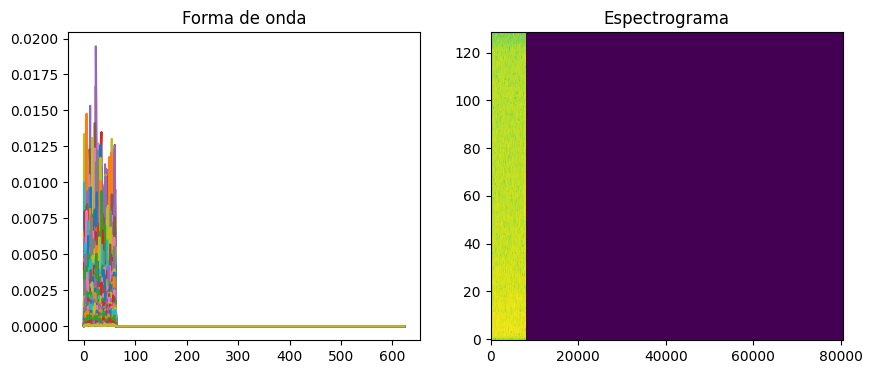

Ejemplo 4:
Etiqueta real: español
Predicción: japonés


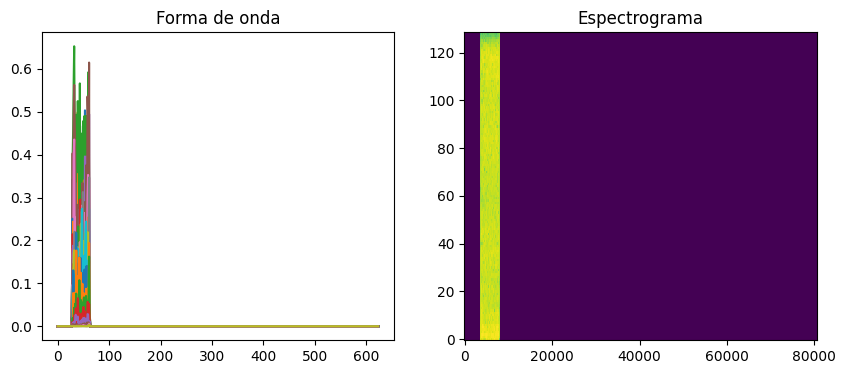

Ejemplo 5:
Etiqueta real: inglés
Predicción: japonés


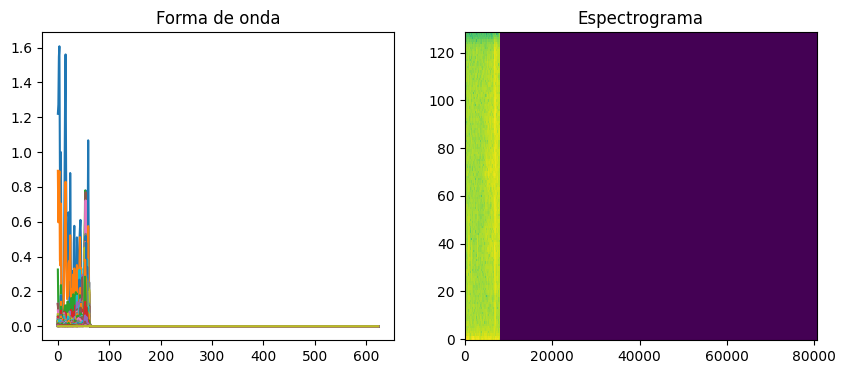

In [99]:
# Crear un batch del conjunto de prueba
test_batch = next(iter(val_spectrogram_ds))

# Separar espectrogramas y etiquetas reales
spectrograms, true_labels = test_batch

# Realizar predicciones
predictions = cnn_model.predict(spectrograms)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Mostrar resultados para algunos ejemplos
for i in range(5):  # Mostrar los primeros 5 ejemplos
    print(f"Ejemplo {i + 1}:")
    print(f"Etiqueta real: {label_names[true_labels[i].numpy()]}")
    print(f"Predicción: {label_names[predicted_labels[i]]}")

    # Graficar espectrograma
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(spectrograms[i].numpy().squeeze())
    plt.title("Forma de onda")
    plt.subplot(1, 2, 2)
    plot_spectrogram(spectrograms[i].numpy(), plt.gca())
    plt.title("Espectrograma")
    plt.show()


MODELO RECURRENTE (RNN)

In [96]:
def build_rnn_model(input_shape, num_labels):
    model = models.Sequential([
        layers.Input(shape=(input_shape[0], input_shape[1])),
        # Capas recurrentes
        layers.SimpleRNN(64, activation='tanh', return_sequences=True),
        layers.SimpleRNN(64, activation='tanh'),
        # Capas densas
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        # Capa de salida
        layers.Dense(num_labels),
    ])
    return model


In [97]:
rnn_model = build_rnn_model((input_shape[0], input_shape[1]), num_labels)

# Compilar el modelo RNN
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Entrenar el modelo RNN
rnn_history = rnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)],
)

# Evaluar el modelo RNN
rnn_eval = rnn_model.evaluate(val_spectrogram_ds)
print(f"RNN Validation Loss: {rnn_eval[0]}, RNN Validation Accuracy: {rnn_eval[1]}")


Epoch 1/50
    272/Unknown 86s 307ms/step - accuracy: 0.3542 - loss: 1.3404

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 94s 334ms/step - accuracy: 0.3543 - loss: 1.3402 - val_accuracy: 0.2965 - val_loss: 1.5070
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 92s 337ms/step - accuracy: 0.4326 - loss: 1.2247 - val_accuracy: 0.2469 - val_loss: 1.4298
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 83s 305ms/step - accuracy: 0.4631 - loss: 1.1792 - val_accuracy: 0.2226 - val_loss: 1.6173
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 145s 317ms/step - accuracy: 0.4536 - loss: 1.1695 - val_accuracy: 0.2570 - val_loss: 1.4607
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 95s 348ms/step - accuracy: 0.4878 - loss: 1.1319 - val_accuracy: 0.2313 - val_loss: 1.4444
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 92s 338ms/step - accuracy: 0.5016 - loss: 1.1041 - val_accuracy: 0.2391 - val_loss: 1.4278
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 137s 320ms/step - accuracy: 0.5009 - loss: 1.0955 - val_accuracy: 0.3263 - val_loss: 1.3656
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 146s 336ms/step - accuracy: 0.5053 - loss: 1.1086 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
Ejemplo 1:
Etiqueta real: japonés
Predicción: francés


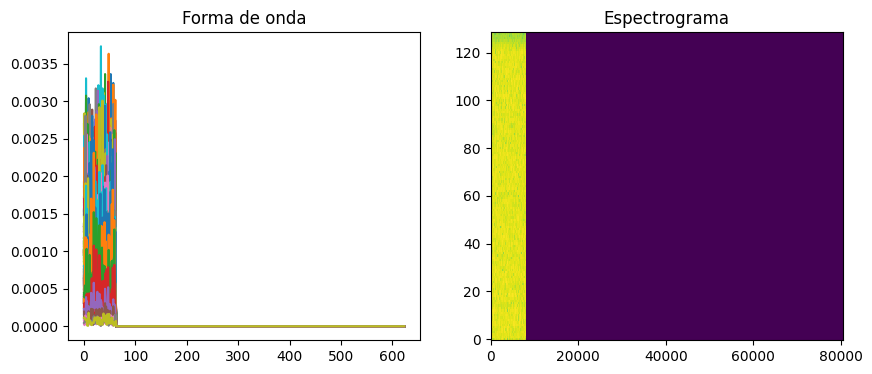

Ejemplo 2:
Etiqueta real: japonés
Predicción: francés


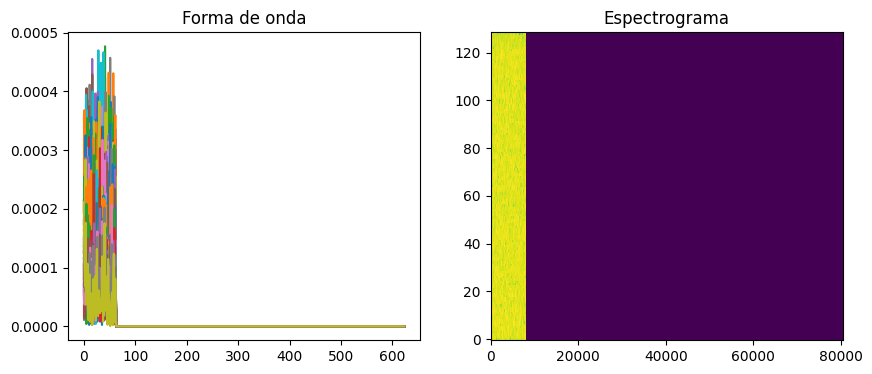

Ejemplo 3:
Etiqueta real: inglés
Predicción: francés


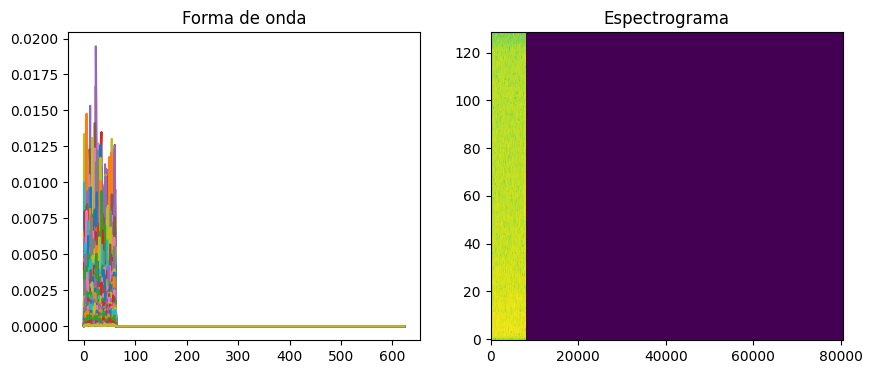

Ejemplo 4:
Etiqueta real: español
Predicción: francés


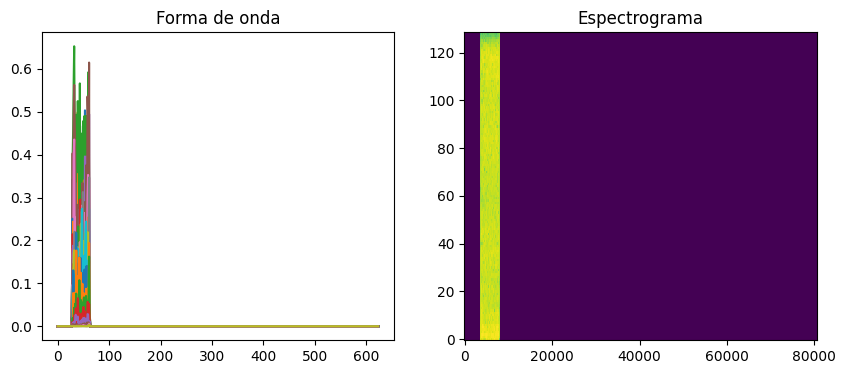

Ejemplo 5:
Etiqueta real: inglés
Predicción: francés


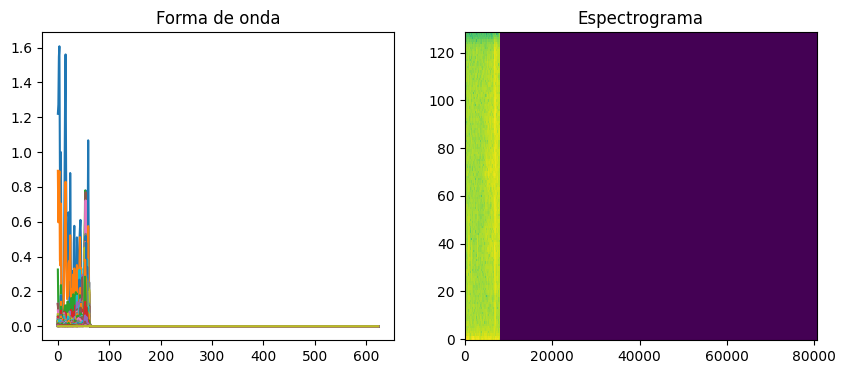

In [100]:
# Crear un batch del conjunto de prueba
test_batch = next(iter(val_spectrogram_ds))

# Separar espectrogramas y etiquetas reales
spectrograms, true_labels = test_batch

# Realizar predicciones con el modelo RNN
predictions = rnn_model.predict(spectrograms)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Mostrar resultados para algunos ejemplos
for i in range(5):  # Mostrar los primeros 5 ejemplos
    print(f"Ejemplo {i + 1}:")
    print(f"Etiqueta real: {label_names[true_labels[i].numpy()]}")
    print(f"Predicción: {label_names[predicted_labels[i]]}")

    # Graficar espectrograma
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(spectrograms[i].numpy().squeeze())
    plt.title("Forma de onda")
    plt.subplot(1, 2, 2)
    plot_spectrogram(spectrograms[i].numpy(), plt.gca())
    plt.title("Espectrograma")
    plt.show()


COMPARACION DE MODELOS

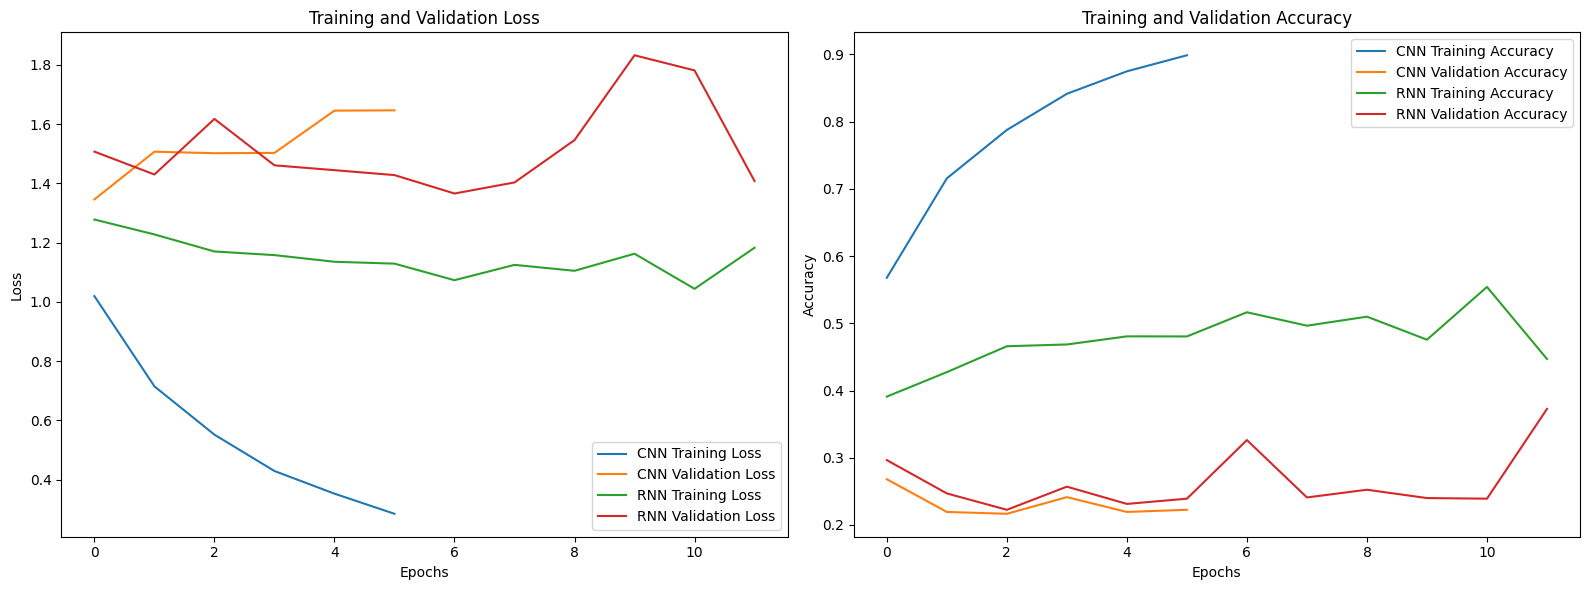

In [98]:
# Graficar los resultados del entrenamiento y validación de ambos modelos
plt.figure(figsize=(16, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(cnn_history.epoch, cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.epoch, cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.plot(rnn_history.epoch, rnn_history.history['loss'], label='RNN Training Loss')
plt.plot(rnn_history.epoch, rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(cnn_history.epoch, cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.epoch, cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(rnn_history.epoch, rnn_history.history['accuracy'], label='RNN Training Accuracy')
plt.plot(rnn_history.epoch, rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()
